# Face detection

Although Medusa's main focus is 3D/4D reconstruction, it also contains functionality for face detection, facial landmark prediction, and cropping as these steps often need to be performed before feeding images into reconstruction models. 

In this tutorial, we will demonstrate Medusa's face detection functionality.

## Detection on (single) images

The first step in many face analysis pipelines is _face detection_. Medusa contains two classes that perform face detection:

* `SCRFDetector`: a detection model based on InsightFace's SCRFD model `citep`{};
* `YunetDetector`: a detection model implemented in OpenCV

We recommend using the `SCRFDetector` as our experience is that it is substantially more accurate than `YunetDetector` (albeit a bit slower when run on CPU); if you want to use the `YunetDetector`, make sure to install OpenCV first (`pip install python-opencv`). So we'll use the `SCRFDetector` for the rest of this section.


In [1]:
from medusa.detect import SCRFDetector

Under the hood, `SCRFDetector` uses an ONNX model provided by InsightFace, but our implementation is quite a bit faster than the original InsightFace implementation as ours uses PyTorch throughout (rather than a mix of PyTorch and numpy).

The `SCRFDetector` takes the following inputs upon initialization:

* `det_size`: size to resize images to before passing to the detection model;
* `det_threshold`: minimum detection threshold (float between 0-1)
* `nms_threshold`: non-maximum suppression threshold (boxes overlapping more than this proportion are removed)
* `device`: either "cpu" or "cuda" (determined automatically by default)

The most important arguments are `det_size` and `det_threshold`; a higher `det_size` (a tuple with two integers, width x height) leads to potentially more accurate detections but slower processing; increasing `det_threshold` leads to more conservative detections (fewer false alarms, but more misses) and vice versa.

In our experience, the defaults are fine for most images/videos:

In [2]:
detector = SCRFDetector()

Now let's apply it to some example data. We'll use a single frame from out example video:

In [13]:
from medusa.data import get_example_image
img = get_example_image(load=True)

Here, `img` represents is loaded as a PyTorch tensor, but the detectors in Medusa can deal with paths to images or numpy arrays, too. Now, to process this image with the detector, we'll call the `detector` object as if it is a function (which internally triggers the `__call__` method):

In [14]:
det = detector(img)

The output of the detector call, `det`, contains a dictionary with information:

In [15]:
det.keys()

dict_keys(['conf', 'bbox', 'lms', 'img_idx', 'n_img'])

Notably, all values of the dictionary are PyTorch tensors. The most important keys are:

* `conf`: the confidence of each detection (0-1)
* `lms`: a set of five landmark coordinates per detection
* `bbox`: a bounding box per detection

Let's take a look at `conf`:

In [16]:
conf = det['conf']
print(f"Conf: {conf.item():.3f}, shape: {tuple(conf.shape)}")

Conf: 0.884, shape: (1,)


So for this image, there is only one detection with a confidence of 0.884. Note that there may be more than one detection per image when there are more faces in the image! 

Now, let's also take a look at the bounding box for the detection:

In [17]:
det['bbox']

tensor([[187.4763,  20.0963, 414.5220, 337.8104]], device='cuda:0')

The bounding box contains four values (in pixel units) that represent the box' mimimum x-value, minimum y-value, maximum x-value, and maximum y-value (in that order). We can in fact visualize this bounding box quite straightforwardly using `torchvision`:

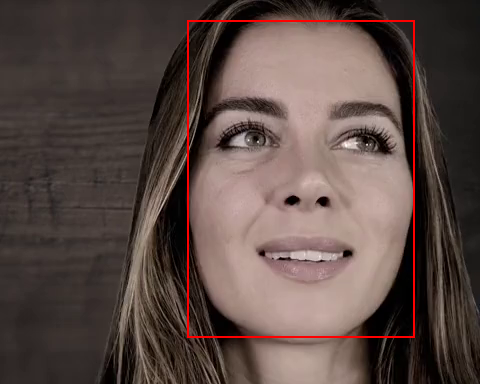

In [30]:
import torch
from IPython.display import Image
from torchvision.utils import draw_bounding_boxes, save_image

# Note that `draw_bounding_boxes` expects the img to be in C x H x W format and uint8, 
# so squeeze out batch dimension and convert float32 to uint8
red = (255, 0, 0)
img = img.squeeze(0).to(torch.uint8)
img_draw = draw_bounding_boxes(img, det['bbox'], colors=red, width=2)

# Save image to disk and display in notebook
save_image(img_draw.float(), 'bbox.png', normalize=True)
Image('bbox.png')

Looks like a proper bounding box! Now, let's finally look at the predicted facial landmarks:

In [31]:
det['lms']  # B x 5 x 2

tensor([[[249.6934, 138.3164],
         [364.9851, 140.5700],
         [311.6083, 185.3770],
         [256.7564, 250.2902],
         [357.6646, 251.7064]]], device='cuda:0')

As you can see, each detection also comes with 5 landmarks consisting of two values (one for X, one for Y) in pixel units. As we'll show below (again, using `torchvision`), these landmarks refer to the left eye, right eye, tip of the nose, left mouthcorner, and right mouth corner:

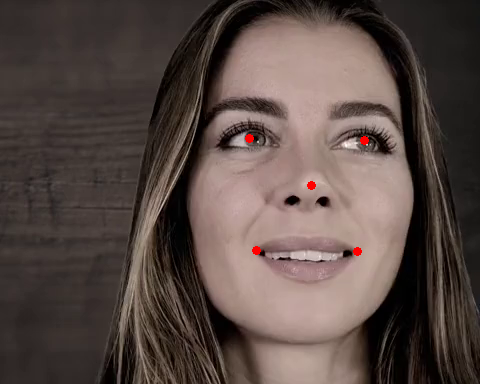

In [33]:
from torchvision.utils import draw_keypoints

# Note that `draw_keypoints` also expects the img to be in C x H x W format
img_draw = draw_keypoints(img, det['lms'], colors=red, radius=4)

# Save image to disk and display in notebook
save_image(img_draw.float(), 'lms.png', normalize=True)
Image('lms.png')

## Detection on batches of images

Thus far, we only applied face detection to a single image, but Medusa's face detectors also work on batches of images such that it can be easily used to process video data, which gives us a good excuse to showcase Medusa's powerful `BatchResults` class (explained later).

Let's try this out on our example video, which we load in batches using Medusa's `VideoLoader`:

In [39]:
from medusa.data import get_example_video
from medusa.io import VideoLoader

vid = get_example_video()
loader = VideoLoader(vid, batch_size=64)

# The loader can be used as an iterator (e.g. in a for loop), but here we only
# load in a single batch; note that we always need to move the data to the desired
# device (CPU or GPU)
batch = next(iter(loader))
batch = batch.to(loader.device)

# B (batch size) x C (channels) x H (height) x W (width)
print(batch.shape)

torch.Size([64, 3, 384, 480])


Initialize the detector as usual and call it on the batch of images like we did on a single image:

In [41]:
detector = SCRFDetector()
out = detector(batch)

print(out.keys())
print(out['bbox'].shape)

dict_keys(['conf', 'bbox', 'lms', 'img_idx', 'n_img'])
torch.Size([64, 4])


To visualize the detection results of this batch of images, we could write a for-loop and use `torchvision` to create for each face/detection and image with the bounding box and face landmarks, but Medusa has a specialized class for this type of batch data to make aggregation and visualization easier:

In [42]:
from medusa.containers import BatchResults
from IPython.display import Video

# `BatchResults` takes any output from a detector model (or crop model) ...
results = BatchResults(**out)

# ... which it'll then visualize as a video (or, if video=False, a set of images)
results.visualize('./test.mp4', batch, video=True, fps=loader._metadata['fps'])

# Embed in notebook
Video('./test.mp4', embed=True)

The `BatchResults` class is especially useful when dealing with multiple batches of images (which will be the case for most videos). When dealing with multiple batches, initialize an "empty" `BatchResults` object before any processing, and then in each iteration call its `add` method with the results from the detector.

Here, we show an example for three consecutive batches; note that `BatchResults` will store anything you give it, so here we're also giving it the raw images (using the `images=batch`):

In [57]:
loader = VideoLoader(get_example_video(n_faces=2))
results = BatchResults()
for i, batch in enumerate(loader):
    batch = batch.to(loader.device)
    out = detector(batch)
    results.add(images=batch, **out)

    if i == 2:
        break

Right now, the `results` object contains for each detection attribute (like `lms`, `conf`, `bbox`, etc) a list with one value for each batch:

In [58]:
# List of length 3 (batches), with each 64 values (batch size)
results.conf

[tensor([0.8863, 0.8227, 0.8861, 0.8192, 0.8868, 0.8186, 0.8862, 0.8176, 0.8880,
         0.8181, 0.8861, 0.8167, 0.8916, 0.8136, 0.8912, 0.8116, 0.8836, 0.8031,
         0.8835, 0.8020, 0.8846, 0.7994, 0.8844, 0.7998, 0.8855, 0.8021, 0.8853,
         0.8025, 0.8805, 0.8020, 0.8806, 0.8002, 0.8801, 0.8010, 0.8799, 0.8009,
         0.8747, 0.8016, 0.8753, 0.8002, 0.8735, 0.8013, 0.8739, 0.8018, 0.8739,
         0.8019, 0.8734, 0.8025, 0.8759, 0.8029, 0.8760, 0.8018, 0.8723, 0.7966,
         0.8719, 0.7967, 0.8609, 0.7933, 0.8607, 0.7927, 0.8756, 0.7921, 0.8756,
         0.7925], device='cuda:0'),
 tensor([0.8586, 0.7972, 0.8593, 0.7984, 0.8390, 0.7968, 0.8380, 0.7957, 0.8365,
         0.7893, 0.8371, 0.7910, 0.8280, 0.7969, 0.8278, 0.7969, 0.8298, 0.8070,
         0.8301, 0.8071, 0.8353, 0.8162, 0.8352, 0.8153, 0.8399, 0.8205, 0.8388,
         0.8204, 0.8447, 0.8217, 0.8450, 0.8211, 0.8561, 0.8195, 0.8567, 0.8192,
         0.8674, 0.8237, 0.8675, 0.8243, 0.8716, 0.8239, 0.8715, 0.8262, 

We can concatenate everything by calling the object's `concat` method:

In [59]:
results.concat()
results.conf.shape  # 192 (= 3 * 64)

torch.Size([192])

Now, we can visualize the results as before (note that we give it the raw images as well):

In [60]:
results.visualize('./test.mp4', results.images, video=True, fps=loader._metadata['fps'])
Video('./test.mp4', embed=True)